### Wafer dataset

In [ ]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
#from pymfe.mfe import MFE
import csv
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from scipy.io import arff
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import random
random.seed(1)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import scipy
from scipy.stats import multivariate_normal

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Layer
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten 
from tensorflow.keras import backend as K
import scipy
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

In [ ]:

Traindata, Trainmeta = arff.loadarff('Wafer_TRAIN.arff')
Testdata, Testmeta = arff.loadarff('Wafer_TEST.arff')
df_Train = pd.DataFrame(Traindata)
df_Test =  pd.DataFrame(Testdata)
df_Train.info()
df_Train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 153 entries, att1 to target
dtypes: float64(152), object(1)
memory usage: 1.2+ MB


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,att11,att12,att13,att14,att15,att16,att17,att18,att19,att20,att21,att22,att23,att24,att25,att26,att27,att28,att29,att30,att31,att32,att33,att34,att35,att36,att37,att38,att39,att40,...,att114,att115,att116,att117,att118,att119,att120,att121,att122,att123,att124,att125,att126,att127,att128,att129,att130,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140,att141,att142,att143,att144,att145,att146,att147,att148,att149,att150,att151,att152,target
0,-1.602294,-1.670823,-1.693666,-1.699377,-1.699377,-1.703660,-1.703660,-1.703660,-1.703660,-1.703660,-0.734257,-0.976964,0.462150,0.946137,1.444402,1.527208,1.622864,1.668550,1.704242,1.718519,1.718519,1.787048,1.741362,1.727085,1.718519,1.718519,1.718519,1.714236,1.718519,1.714236,1.722802,1.722802,1.722802,1.718519,1.600021,-1.346737,-1.589444,-1.639414,-1.666540,-1.676534,...,0.283688,0.275122,0.275122,0.275122,0.275122,0.275122,0.275122,0.275122,0.275122,0.279405,0.279405,0.275122,0.279405,0.275122,0.279405,0.275122,0.275122,-1.014084,-1.132583,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,b'1'
1,1.084591,1.084591,1.084591,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.084591,1.084591,1.084591,1.084591,1.084591,1.084591,1.065308,1.084591,1.084591,-0.593106,-0.207429,0.101114,0.197533,0.255385,0.293952,0.332520,0.351804,0.371088,0.390372,0.390372,0.409656,0.409656,1.065308,1.084591,1.065308,1.084591,1.065308,1.084591,1.065308,1.065308,1.065308,...,-0.978784,-0.978784,-0.959500,-0.978784,-0.959500,-0.959500,-0.959500,-0.978784,0.949604,1.046024,1.065308,1.084591,1.084591,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,b'1'
2,0.362689,0.362689,0.362689,0.393316,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.393316,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.362689,0.852721,-0.402987,-0.402987,-0.402987,-0.402987,-0.433614,-0.433614,-0.402987,-0.402987,-0.402987,-0.372360,-0.402987,-0.402987,0.362689,0.362689,0.362689,0.362689,0.362689,...,-0.372360,-0.372360,-0.341733,-0.402987,-0.402987,-0.402987,-0.372360,-0.372360,-0.372360,-0.341733,-0.372360,-0.402987,-0.372360,-0.372360,-0.402987,-0.402987,-0.402987,-0.402987,-0.402987,-0.372360,-0.402987,-0.372360,-0.402987,-0.402987,-0.402987,-0.402987,0.393316,0.393316,0.393316,0.393316,0.393316,0.393316,0.362689,0.393316,0.393316,0.393316,0.393316,0.393316,0.393316,b'1'
3,-1.094523,-1.094523,-1.094523,-1.096732,-1.094523,-1.096732,-1.094523,-1.094523,-1.094523,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,0.707507,1.078513,0.992386,0.767133,0.608130,0.453544,0.360793,0.287916,0.208415,0.157622,0.106830,0.078121,0.051621,-0.937729,-1.094523,-1.094523,-1.094523,-1.094523,-1.094523,-1.094523,-1.094523,...,1.016679,1.014470,1.010053,1.003428,1.001220,1.001220,0.994595,0.990178,0.985761,-0.796394,-1.094523,-1.094523,-1.096732,-1.094523,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,b'1'
4,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.105914,-1.105914,-1.103761,-1.105914,-1.103761,-1.103761,-1.103761,-1.103761,-1.105914,0.775413,1.005735,0.740972,0.512802,0.304005,0.183462,0.077987,0.015563,-0.033945,-0.083454,-0.115742,-0.150183,-0.171708,-0.976761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,...,0.999278,0.997125,0.994972,0.997125,0.990667,0.986362,

In [ ]:
df_Test.shape

(6164, 153)

target    object
dtype: object
target    object
dtype: object


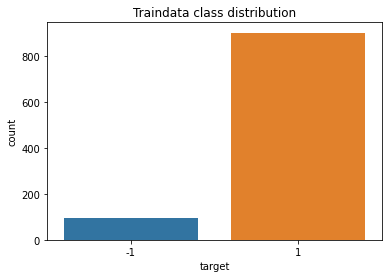

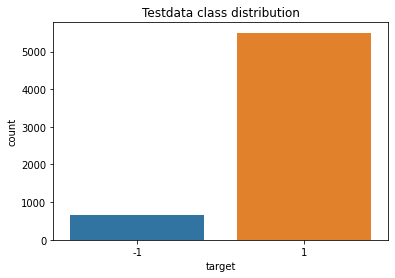

In [ ]:
#Non-numerical datatype in the train and test set
print(df_Train.dtypes[df_Train.dtypes == object])
print(df_Test.dtypes[df_Test.dtypes == object])
#Convert the target attribute to integer
Train_target = pd.DataFrame()
Test_target = pd.DataFrame()
Train_target['target'] = df_Train['target'].astype(np.int8).copy()
Test_target['target'] = df_Test['target'].astype(np.int8).copy()
#np.sum(Train_target == -1)
ax = plt.figure()
ax = sns.countplot(x='target',data=Train_target).set_title('Traindata class distribution')
plt.savefig('Traindataimbalance.png')
ax1 = plt.figure()
ax1 = sns.countplot(x='target',data=Test_target).set_title('Testdata class distribution')
plt.savefig('Testdataimbalance.png')

In [ ]:
#Training Datast
y_train = np.array(Train_target)
df_Train['target'] =y_train
y_train = np.array(df_Train['target']) #np.array(df_Test_z['target'])
#TrainData = np.array(df_Train.drop('target', axis=1)) #np.array(df_Test_z.drop('target', axis=1))
print("Majority class =",np.sum(y_train==1))
print("Minority class =",np.sum(y_train==-1))

Majority class = 903
Minority class = 97


In [ ]:
#Test data preparation
y_test = np.array(Test_target)
df_Test['target'] =y_test
y_test = np.array(df_Test['target']) #np.array(df_Test_z['target'])
#TestData = np.array(df_Test.drop('target', axis=1)) #np.array(df_Test_z.drop('target', axis=1))
print("Majority class =",np.sum(y_test==1))
print("Minority class =",np.sum(y_test==-1))


Majority class = 5499
Minority class = 665


#### Training and Test dataset preparation for the experiment

In [ ]:
Datanew = pd.concat([df_Train,df_Test])
y = Datanew.target
Datanew = np.array(Datanew.drop('target', axis=1))
Datanew.shape
Trn_imb_set = (50,3000)
imb_index = np.insert(np.cumsum(Trn_imb_set), 0, 0)
classes = np.array([-1,1])
TrainData = np.zeros((np.sum(Trn_imb_set),Datanew.shape[1]))
Tst_imb_set = (712,3402)
Tstimb_index = np.insert(np.cumsum(Tst_imb_set), 0, 0)
TestData = np.zeros((np.sum(Tst_imb_set),Datanew.shape[1]))

In [ ]:
for i in range(classes.shape[0]):
    yind = np.where(y == classes[i])
    sel = np.random.choice(yind[0], Trn_imb_set[i], replace=False)
    TrainData[imb_index[i]:imb_index[i+1],:] = Datanew[sel]
    nsel = np.setdiff1d(yind,sel)
    TestData[Tstimb_index[i]:Tstimb_index[i+1],:] = Datanew[nsel]#np.delete(Datanew,sel,axis =0)
        
y_train = np.hstack([np.ones((50,))*-1,np.ones((3000,))])
y_train = y_train.astype('int8')
y_test = np.hstack([np.ones((712,))*-1,np.ones((3402,))])
y_test = y_test.astype('int8')


In [ ]:
TestData.shape


(4114, 152)

In [ ]:
#Normalize the data between +1 and -1
mmscaler    = MinMaxScaler(feature_range=(-1,1))
TrainData   = mmscaler.fit_transform(TrainData)

In [ ]:
TestData   = mmscaler.transform(TestData)

In [ ]:
y_trn = y_train

### VAE

#### VAE code is adopted and modified from the following reference.
#### https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter8-vae/vae-mlp-mnist-8.1.1.py 

In [ ]:
start_dimension = 152
input_shape = (152, )
intermediate_dim = 100
batch_size = 200
latent_dim = 4 
epochs = 700

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Encoder

In [ ]:
# Encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 152)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          15300       ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 4)            404         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 4)            404         ['dense[0][0]']                  
                                                                                            

### Decoder

In [ ]:
# Decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(start_dimension, activation='tanh')(x)

# instantiate decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 100)               500       
                                                                 
 dense_2 (Dense)             (None, 152)               15352     
                                                                 
Total params: 15,852
Trainable params: 15,852
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
from sklearn.model_selection import train_test_split 
X_trainvae, X_valvae, y_trvae, y_valvae = train_test_split(TrainData, TrainData, 
                                                    test_size=0.15, random_state=11)

In [ ]:
start_time = time.time()

In [ ]:
if __name__ == '__main__':
    
    loss = 'mse'
    models = (encoder, decoder)
    
    if loss == 'bce':
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)
        
    reconstruction_loss *= start_dimension
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    
    vae.fit(X_trainvae,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_valvae, None))

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 152)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          16108       ['encoder_input[0][0]']          
                                 (None, 4),                                                       
                                 (None, 4)]                                                       
                                                                                                  
 decoder (Functional)           (None, 152)          15852       ['encoder[0][2]']                
                                                                                            

In [ ]:
def latent_data(vae, data):
    encoder, decoder = vae
    z_mean, _, _ = encoder.predict(data)
    return z_mean
LS_train = latent_data(models, TrainData)
LS_test = latent_data(models, TestData)

### MSPO

In [ ]:
    #def SPOfn(latent_space_im,mino,majo,y_d):
       
    latent_space_im = LS_train
    mino = -1
    majo = 1
    y_d = y_trn
    
    nTarget = np.sum(y_d == majo)


    posy = y_d == mino
    negy = y_d != mino
    P = latent_space_im[np.where(posy == True)[0],:]
    N = latent_space_im[np.where(negy == True)[0],:]

    #print(len(P),len(N))

    poscnt = P.shape[0]
    NumToGen = nTarget - poscnt
    Me  = np.mean((P),axis = 0)
    PCov = np.cov(P.T)
    
    [D,V] = np.linalg.eig(PCov)
    #d = [D[x,x] for x in range(D.shape[0])]
    d = D
    
    #d = d.astype(np.float32)
    n = P.shape[1] #Feature dimension
    idx = d.argsort()[::-1]   
    d = d[idx]
    V = V[:,idx]
    #d = d[0:n+1]
    #v = V[:,n::-1]
    
    

    Ind = (d<= 5e-04)

    if np.sum(Ind) != 0:
        M = (list(Ind).index(True)+1)
    else:
        M = n
        
   
    PN = np.concatenate((P,N),axis=0)
    TCov = np.cov(PN.T)
    dT    = np.dot(V.T,np.dot(TCov, V))
    dT = [dT[x,x] for x in range(dT.shape[0])]
    

    #Modify the Eigen spectrum according to a 1-Parameter Model
    dMod  = np.zeros((n,1))
    Alpha = d[0]* d[M-1]*(M-1) /(d[0] - d[M-1]) #d[0]* d[M-1]*(M-1) /(d[0] - d[M-1])
    Beta  = ((M)*d[M-1] - d[0])/(d[0] - d[M-1])
        
 
    for i in range(n):
        if i<M-1:

            dMod[i] = d[i]
        else:
            dMod[i] = Alpha/(i+1+Beta)
            if dMod[i] > dT[i]:
                dMod[i] = dT[i]

    R = 1.0
    d = dMod
            
    ########################################
    
    
    Rn = M
    Un = len(Me) - M
    Ptemp = P

    MuR = np.zeros((Rn,1)) #mlayer#
    SigmaR = np.identity((Rn)) #v_mat #

    MuU = np.zeros((Un,1))
    SigmaU = np.identity((Un))

    SampGen = np.zeros((int(NumToGen*R), len(Me)))
    SampSel = np.zeros((int(NumToGen), len(Me)))
    Prob    = np.zeros((int(NumToGen*R),1))

    cnt = 0
    DD = np.sqrt(d)
    MuR = MuR.reshape(MuR.shape[0],)
    MuU = MuU.reshape(MuU.shape[0],)
    
    while cnt < int(R*NumToGen):
        
        
        aR =  np.random.multivariate_normal(MuR.T, SigmaR, 1)
        #print(aR)
        #scipy.stats.multivariate_normal(MuR.T, SigmaR, 1)
        tp = multivariate_normal.pdf(aR, MuR, SigmaR) #aR.pdf(1)
        #print(tp)

        if Un > 0:
            aU = np.random.multivariate_normal(MuU, SigmaU, 1)
            #scipy.stats.multivariate_normal(MuU, SigmaU, 1)
            a = np.multiply(np.concatenate((aR,aU),axis=1).T,DD)   #The vector in Eigen transformed domain;
        else:
            a = np.multiply(aR.T,DD)
            #print(a)

        x = np.dot(a.T,V.T)+ Me
        #print(x)
        #pdb.set_trace()
        PDist = np.sqrt(np.sum(np.square((x-P)),axis=1))
        NDist = np.sqrt(np.sum(np.square((x-N)),axis=1))

        [tmp,ind]  = [np.min(NDist),np.argmin(NDist)]

        if np.min(PDist) < tmp:
            PPDist = np.sqrt(np.sum(np.square((N[ind,:]-P)),axis=1))
            if tmp >= np.min(PPDist) and tmp <= np.max(PPDist):
                SampGen[cnt,:] = x
                Prob[cnt,0] = tp  
                cnt+=1
                Ptemp = np.concatenate((Ptemp,SampGen),axis =0)

    for i in range (int(R*NumToGen)):
        [tmp,ind]  = [np.min(Prob),np.argmin(Prob)]
        Prob[ind] =  np.inf
        SampSel[i,:] = SampGen[ind,:]

    Ynew = SampSel #np.concatenate((SampSel,P),axis = 0)
    #Total = np.concatenate((Ynew,N),axis = 0)
    
    #return Ynew


In [ ]:
Datanew = np.concatenate((SampSel,P),axis = 0)
Total = np.concatenate((Datanew,N),axis = 0)
label = np.zeros((Total.shape[0],))
label[0:Datanew.shape[0]] = -1
label[Datanew.shape[0]:Total.shape[0]] = 1

### MLP on SPO latent space

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:

def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.prod(tp_rate)**(1/cm.shape[0])
    return ACSA, GM

0.9941662615459407
              precision    recall  f1-score   support

    class -1       0.98      0.99      0.98       712
     class 1       1.00      1.00      1.00      3402

    accuracy                           0.99      4114
   macro avg       0.99      0.99      0.99      4114
weighted avg       0.99      0.99      0.99      4114



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


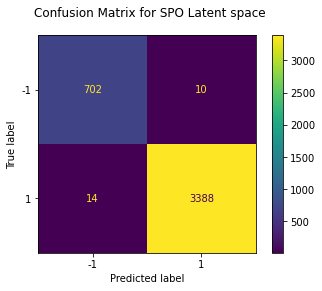

In [ ]:
X_train = Total
y_trnmlp = label
X_test = (LS_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3,3))
X_trainscaled= X_train #mm_X.fit_transform(X_train)
X_testscaled= X_test #mm_X.transform(X_test)

clf = MLPClassifier(batch_size =16,hidden_layer_sizes=(8,16,10,7,),activation="tanh",
                    solver = 'sgd',random_state=1,max_iter = 5000,learning_rate_init = 0.0058,
                   learning_rate = 'adaptive')
#clf = MLPClassifier(hidden_layer_sizes=(4,12,6,5),activation="tanh",learning_rate_init = 0.0008,random_state=1,max_iter = 5000)
clf.fit(X_trainscaled, y_trnmlp)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for SPO Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
#print('F1score:',f1_score(y_test, y_pred, average='weighted'))
#print('The geometric mean is {}'.format(geometric_mean_score(y_test,y_pred)))
acsa,gm = metrics_aa_gm(y_pred, y_test)
print("Metrics for VAE-LSSPO technique")
print('ACSA =',acsa,'GM=',gm)

Metrics for VAE-LSSPO technique
ACSA = 0.9909199149211634 GM= 0.9909074769952257


In [ ]:
# kf = KFold(n_splits=10,shuffle = True)
# print("Cross Validation")

# for train_indices, test_indices in kf.split((X_trainscaled)):
#     clf.fit(X_trainscaled[train_indices], y_trnmlp[train_indices])
#     # print(clf.score(X_testscaled, y_test))

#     y_pred=clf.predict(X_testscaled)
#     print('F1score:',f1_score(y_test, y_pred, average='weighted'),"GM: {}".format(geometric_mean_score(y_test,y_pred)))
#     #print('The geometric mean is {}'.format(geometric_mean_score(y_test,y_pred)))
    

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
score_lsspo = silhouette_score(Total, label, metric='l2')
print("Silhouette score for VAE-LSSPO latent data =",score_lsspo)

Silhouette score for VAE-LSSPO latent data = 0.3385134427805329


In [ ]:
print('Time taken:',time.time()-start_time)

Time taken: 210.1985342502594


#### No oversampling

In [ ]:
score_noOS = silhouette_score(LS_train, y_trn, metric='l2')
print("Silhouette score for VAE latent data =",score_noOS)

Silhouette score for VAE latent data = 0.20644955


##### MLP on latent data without oversampling

0.9769081186193486
              precision    recall  f1-score   support

    class -1       0.98      0.88      0.93       712
     class 1       0.98      1.00      0.99      3402

    accuracy                           0.98      4114
   macro avg       0.98      0.94      0.96      4114
weighted avg       0.98      0.98      0.98      4114



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


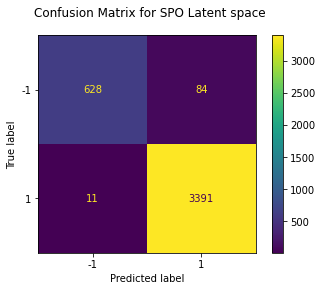

In [ ]:
X_train = LS_train
y_trnmlp = y_trn
X_test = (LS_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3,3))
X_trainscaled= X_train #mm_X.fit_transform(X_train)
X_testscaled= X_test #mm_X.transform(X_test)

clf = MLPClassifier(batch_size =16,hidden_layer_sizes=(8,16,10,7,),activation="tanh",
                    solver = 'sgd',random_state=1,max_iter = 5000,learning_rate_init = 0.0058,
                   learning_rate = 'adaptive')
#clf = MLPClassifier(hidden_layer_sizes=(4,12,6,5),activation="tanh",learning_rate_init = 0.0008,random_state=1,max_iter = 5000)
clf.fit(X_trainscaled, y_trnmlp)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for SPO Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
acsa,gm = metrics_aa_gm(y_pred, y_test)
print("Metrics for no oversampling technique")
print('ACSA =',acsa,'GM=',gm)

Metrics for no oversampling technique
ACSA = 0.9393945398939156 GM= 0.9376409480167573


#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(LS_train, y_trn)

0.9837141468157511
              precision    recall  f1-score   support

    class -1       0.98      0.93      0.95       712
     class 1       0.98      1.00      0.99      3402

    accuracy                           0.98      4114
   macro avg       0.98      0.96      0.97      4114
weighted avg       0.98      0.98      0.98      4114



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


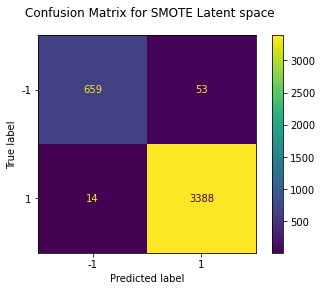

In [ ]:
X_train = X_sm  
y_trnmlp = y_sm
X_test = (LS_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3,3))
X_trainscaled= X_train #mm_X.fit_transform(X_train)
X_testscaled= X_test #mm_X.transform(X_test)

clf = MLPClassifier(batch_size =64,hidden_layer_sizes=(8,32,10,7,),activation="tanh",
                    solver = 'sgd',random_state=1,max_iter = 5000,learning_rate_init = 0.0058,
                   learning_rate = 'adaptive')
#clf = MLPClassifier(hidden_layer_sizes=(4,12,6,5),activation="tanh",learning_rate_init = 0.0008,random_state=1,max_iter = 5000)
clf.fit(X_trainscaled, y_trnmlp)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for SMOTE Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
acsa,gm = metrics_aa_gm(y_pred, y_test)
print("Metrics for SMOTE technique")
print('ACSA =',acsa,'GM=',gm)

Metrics for SMOTE technique
ACSA = 0.9607232857076802 GM= 0.9600796328772736


In [ ]:
score_sm = silhouette_score(X_sm, y_sm, metric='l2')
print("Silhouette score for SMOTE oversampled latent data =",score_sm)

Silhouette score for SMOTE oversampled latent data = 0.23163643


#### ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN 

In [ ]:
oversample = ADASYN()
X_adsn, y_adsn = oversample.fit_resample(LS_train, y_trn)

In [ ]:
score_adsn = silhouette_score(X_adsn, y_adsn, metric='l2')
print("Silhouette score for VAE+ADASYN oversampled data =",score_adsn)

Silhouette score for VAE+ADASYN oversampled data = 0.121660806


0.9837141468157511
              precision    recall  f1-score   support

    class -1       0.98      0.93      0.95       712
     class 1       0.98      1.00      0.99      3402

    accuracy                           0.98      4114
   macro avg       0.98      0.96      0.97      4114
weighted avg       0.98      0.98      0.98      4114



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


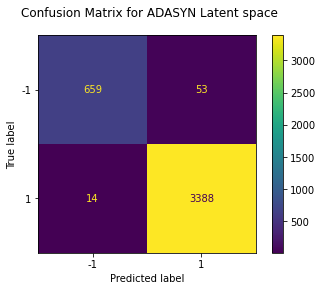

In [ ]:
X_train = X_adsn   
y_trnmlp = y_adsn
X_test = (LS_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3,3))
X_trainscaled= X_train #mm_X.fit_transform(X_train)
X_testscaled= X_test #mm_X.transform(X_test)

clf = MLPClassifier(batch_size =16,hidden_layer_sizes=(8,32,10,7,),activation="tanh",
                    solver = 'sgd',random_state=1,max_iter = 5000,learning_rate_init = 0.0058,
                   learning_rate = 'adaptive')
#clf = MLPClassifier(hidden_layer_sizes=(4,12,6,5),activation="tanh",learning_rate_init = 0.0008,random_state=1,max_iter = 5000)
clf.fit(X_trainscaled, y_trnmlp)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for ADASYN Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+ADASYN+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+ADASYN+MLP
ACSA = 0.9607232857076802 GM= 0.9600796328772736


#### RANDOM SAMPLING

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_rand, y_rand = ros.fit_resample(LS_train, y_trn)

In [ ]:
score_rand = silhouette_score(X_rand, y_rand, metric='l2')
print("Silhouette score for VAE+Random oversampled data =",score_rand)

Silhouette score for VAE+Random oversampled data = 0.21932627


0.9844433641225085
              precision    recall  f1-score   support

    class -1       0.97      0.94      0.95       712
     class 1       0.99      0.99      0.99      3402

    accuracy                           0.98      4114
   macro avg       0.98      0.97      0.97      4114
weighted avg       0.98      0.98      0.98      4114



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


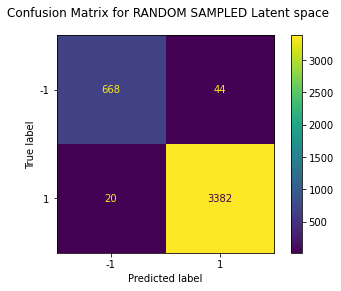

In [ ]:
X_train = X_rand   
y_trnmlp = y_rand
X_test = (LS_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3,3))
X_trainscaled= X_train #mm_X.fit_transform(X_train)
X_testscaled= X_test #mm_X.transform(X_test)

clf = MLPClassifier(batch_size =16,hidden_layer_sizes=(8,32,10,7,),activation="tanh",
                    solver = 'sgd',random_state=1,max_iter = 5000,learning_rate_init = 0.0058,
                   learning_rate = 'adaptive')
#clf = MLPClassifier(hidden_layer_sizes=(4,12,6,5),activation="tanh",learning_rate_init = 0.0008,random_state=1,max_iter = 5000)
clf.fit(X_trainscaled, y_trnmlp)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for RANDOM SAMPLED Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+RANDOM+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+RANDOM+MLP
ACSA = 0.9661616762116138 GM= 0.9657570372039114


#### BORDERLINE SMOTE

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
X_bos, y_bos = BorderlineSMOTE().fit_resample(LS_train, y_trn)

In [ ]:
score_bos = silhouette_score(X_bos, y_bos, metric='l2')
print("Silhouette score for VAE+Borderline SMOTE oversampled data =",score_bos)

Silhouette score for VAE+Borderline SMOTE oversampled data = 0.1418609


0.9795819154107924
              precision    recall  f1-score   support

    class -1       0.98      0.90      0.94       712
     class 1       0.98      1.00      0.99      3402

    accuracy                           0.98      4114
   macro avg       0.98      0.95      0.96      4114
weighted avg       0.98      0.98      0.98      4114



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


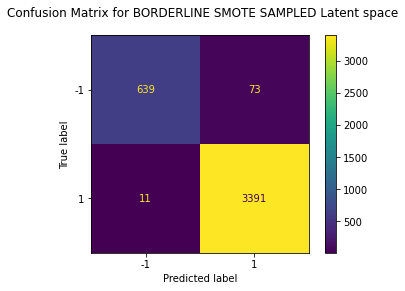

In [ ]:
X_train = X_bos    
y_trnmlp = y_bos
X_test = (LS_test)
y_test = (y_test)

#X_train, X_test, y_train, y_test = train_test_split(X,y_im,random_state=1, test_size=0.1)
sc_X = StandardScaler()
mm_X = MinMaxScaler(feature_range=(-3,3))
X_trainscaled= X_train #mm_X.fit_transform(X_train)
X_testscaled= X_test #mm_X.transform(X_test)

clf = MLPClassifier(batch_size =16,hidden_layer_sizes=(8,32,10,7,),activation="tanh",
                    solver = 'sgd',random_state=1,max_iter = 5000,learning_rate_init = 0.0058,
                   learning_rate = 'adaptive')
#clf = MLPClassifier(hidden_layer_sizes=(4,12,6,5),activation="tanh",learning_rate_init = 0.0008,random_state=1,max_iter = 5000)
clf.fit(X_trainscaled, y_trnmlp)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["-1",'1'])
fig.figure_.suptitle("Confusion Matrix for BORDERLINE SMOTE SAMPLED Latent space")
#plt.savefig('ConfusionMatrixoforiginallatentspace.png')
#plt.show()
target_names = ['class -1', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+BoS+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+BoS+MLP
ACSA = 0.9471192589950392 GM= 0.9458171237127364
